# STIF Open data

In [28]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
pd.set_option('display.max_colwidth',-1)

sns.set_style("whitegrid")
sns.set_context('notebook')

%matplotlib inline
plt.rcParams["figure.figsize"] = (14,6)

%reload_ext autoreload
%autoreload 2

Load data

In [2]:
df = pd.read_feather('../data/processed/profile-2017.feather')

In [3]:
df.head()

,cat_jour,libelle_arret,trnc_horr_60,pourc_validations,heure,sem
0,savs,republique,5h-6h,0.61,5.0,s1-2017
1,dijfp,reuilly-diderot,15h-16h,8.93,15.0,s1-2017
2,dijfp,reuilly-diderot,2h-3h,0.01,2.0,s1-2017
3,dijfp,reuilly-diderot,6h-7h,1.15,6.0,s1-2017
4,johv,reuilly-diderot,0h-1h,0.61,0.0,s1-2017


In [4]:
df = pd.read_feather('../data/raw/profile-2017.feather')
df=df.rename(columns={'libelle_arret':'stop',
                      'cat_jour':'profile',
                  'trnc_horr_60':'slice',
                  'pourc_validations':'value',
                  'heure':'hour'}).drop(columns='index')

In [5]:
df.profile.value_counts()

Jour Ouvré Hors Vacances Scolaires             14395
Jour Ouvré en période de Vacances Scolaires    14184
Dimanche et Jour Férié et les ponts            14087
Samedi Hors Vacances Scolaires                 13888
Samedi en période de Vacances Scolaires        13655
Name: profile, dtype: int64

In [6]:
df.head()

,profile,stop,slice,value,hour,sem
0,Samedi en période de Vacances Scolaires,REPUBLIQUE,5H-6H,0.61,5.0,S1-2017
1,Dimanche et Jour Férié et les ponts,REUILLY-DIDEROT,15H-16H,8.93,15.0,S1-2017
2,Dimanche et Jour Férié et les ponts,REUILLY-DIDEROT,2H-3H,0.01,2.0,S1-2017
3,Dimanche et Jour Férié et les ponts,REUILLY-DIDEROT,6H-7H,1.15,6.0,S1-2017
4,Jour Ouvré Hors Vacances Scolaires,REUILLY-DIDEROT,0H-1H,0.61,0.0,S1-2017


## Data description

**stop**

Metro station

**profile**

Specific profile define by the STIF where the pattern of customers are similar.

For example the usual working week (monday->friday) is a profile, weekend & day-off are another one, ...

**value**

Fraction of the daily traffic. As it it is normalized between 0 and 100, the sum of all slice for a give day should be 100. 

**slice**

Textual representation of the hour

**hour**

Number representing the hour slice. e.g *4* means from 4 to 5h

## Filtering

I'm  only interested by working weekday (monday-friday) at likely buisness hour (7-21h)

In [7]:
df_workday = (df
              .query('profile =="Jour Ouvré Hors Vacances Scolaires" and (hour >= 7 and hour <22)')
              .assign(hour=lambda x :x['hour'].astype(int))
             )

## Checking assumptions 


### Distribution of data per hour





In [8]:
expected_hours = set(range(7,22))
nb_semester = 2

In [9]:
assert set(df_workday.hour.unique()) == expected_hours

In [10]:
df_count_hour = df_workday.groupby('stop').count()['hour']
mask = (df_count_hour== len(expected_hours)*nb_semester)
df_count_hour[~mask]

stop
CHATEAU ROUGE    17
Name: hour, dtype: int64

CHATEAU ROUGE contains only 17 records which make the data not reliable. 

The missing values only concern the S1-2017, S2 seems ok.

It's unlikey that the metro was only open for two hours on a give day.

In [11]:
(df_workday.query('stop == "CHATEAU ROUGE"')
 .sort_values('hour')
 .groupby('sem')
 .count()['hour'])

sem
S1-2017    2 
S2-2017    15
Name: hour, dtype: int64

In [12]:
#filter out inconsistent data
df_workday = df_workday.query('not(stop == "CHATEAU ROUGE" and sem=="S1-2017")')\
                       .drop(columns='profile')

### Data consistency

value should add to 100 for each stop in each semester

In [13]:
df.profile.unique()

array(['Samedi en période de Vacances Scolaires',
       'Dimanche et Jour Férié et les ponts',
       'Jour Ouvré Hors Vacances Scolaires',
       'Jour Ouvré en période de Vacances Scolaires',
       'Samedi Hors Vacances Scolaires'], dtype=object)

In [14]:
pct_check =(df.query("profile =='Jour Ouvré Hors Vacances Scolaires'")
 .groupby(['stop','sem'])['value'].sum())

In [15]:
pct_check.describe()

count    602.000000
mean     99.996993 
std      0.014437  
min      99.960000 
25%      99.990000 
50%      100.000000
75%      100.010000
max      100.030000
Name: value, dtype: float64

There is a slight difference but it is acceptable for our need

## Data exploration

In [16]:
df_workday.value.describe()

count    9015.000000
mean     6.226153   
std      3.454884   
min      0.640000   
25%      3.925000   
50%      5.170000   
75%      7.850000   
max      31.400000  
Name: value, dtype: float64

According to the summary looks like there is a long tail to the right

/home/khalid/.pyenv/versions/3.6.2/envs/paris_metro/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Validation distribution per hour')

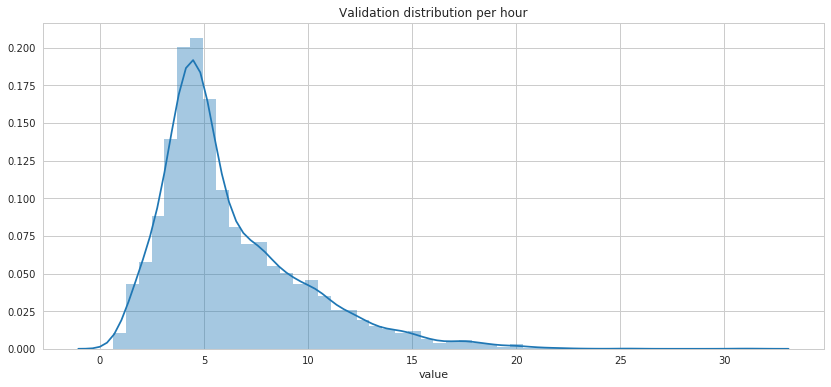

In [31]:
ax = sns.distplot(df_workday.value)
ax.set_title('Validation distribution per hour')

The distribution is  skewed to the right

Identification of outliers with MAD(Median Absolute Deviation) should do the trick 

### Outliers analysis

In [20]:
import numpy as np

#courtesy : 
##idea : http://eurekastatistics.com/using-the-median-absolute-deviation-to-find-outliers/
##code :https://stackoverflow.com/a/29222992/5538961
def doubleMAD(y,thresh=3.5):
    m = np.median(y)
    abs_dev = np.abs(y - m)
    left_mad = np.median(abs_dev[y <= m])
    right_mad = np.median(abs_dev[y >= m])
    y_mad = left_mad * np.ones(len(y))
    y_mad[y > m] = right_mad
    modified_z_score = 0.6745 * abs_dev / y_mad
    modified_z_score[y == m] = 0
    return modified_z_score > thresh

In [21]:
outliers = df_workday[doubleMAD(df_workday.value)]

In [22]:
outliers.describe()

,value,hour
count,44.000000,44.000000
mean,21.130682,10.954545
std,2.599905,4.615215
min,19.090000,8.000000
25%,19.800000,8.000000
50%,20.200000,8.000000
75%,21.257500,18.000000
max,31.400000,18.000000


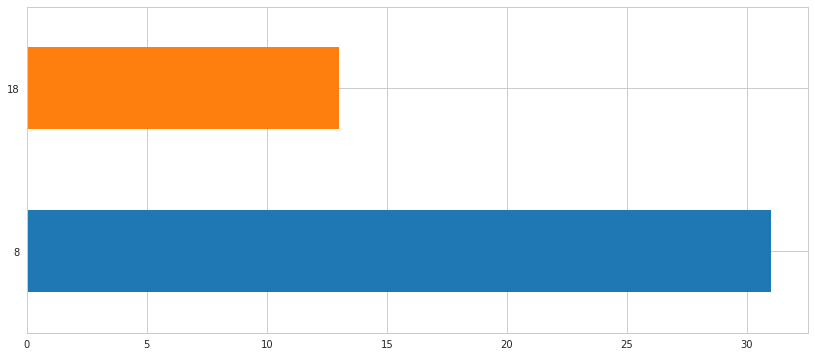

In [30]:
import matplotlib as plt
ax=outliers.hour.value_counts().plot(kind='barh')

These outliers seems to make sense, 8h and 18h are the rush hour expected in a weekday

In [24]:
ratp = pd.read_feather('../data/processed/ratp_line.feather')

## When should I take the metro to avoid too many people ?

In [25]:
#ax=sns.boxplot(x='heure',y='pourc_validations',hue='sem',data=df_ouvre.query('heure>=6'))

In regular weekday, on average, you'll be with a lot of users in the metro between 8-9h.

Before 8h or after 10h seems like a better bet.

It's harder to avoid the pack at the end of the day as the crowd appear between 17-19h.


(0, 12)

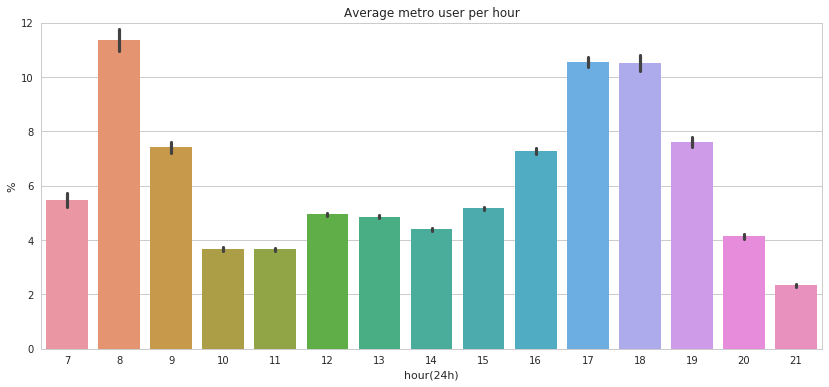

In [29]:
ax=sns.barplot(x='hour',y='value',data=df_workday)
ax.set_title('Average metro user per hour')
ax.set_ylabel('%')
ax.set_xlabel('hour(24h)')
ax.set_ylim(0,12)

Overview of other profiles :

In [40]:
df_clean = (df
              .query('(hour >= 7 and hour <22)')
              .assign(hour=lambda x :x['hour'].astype(int))
             )

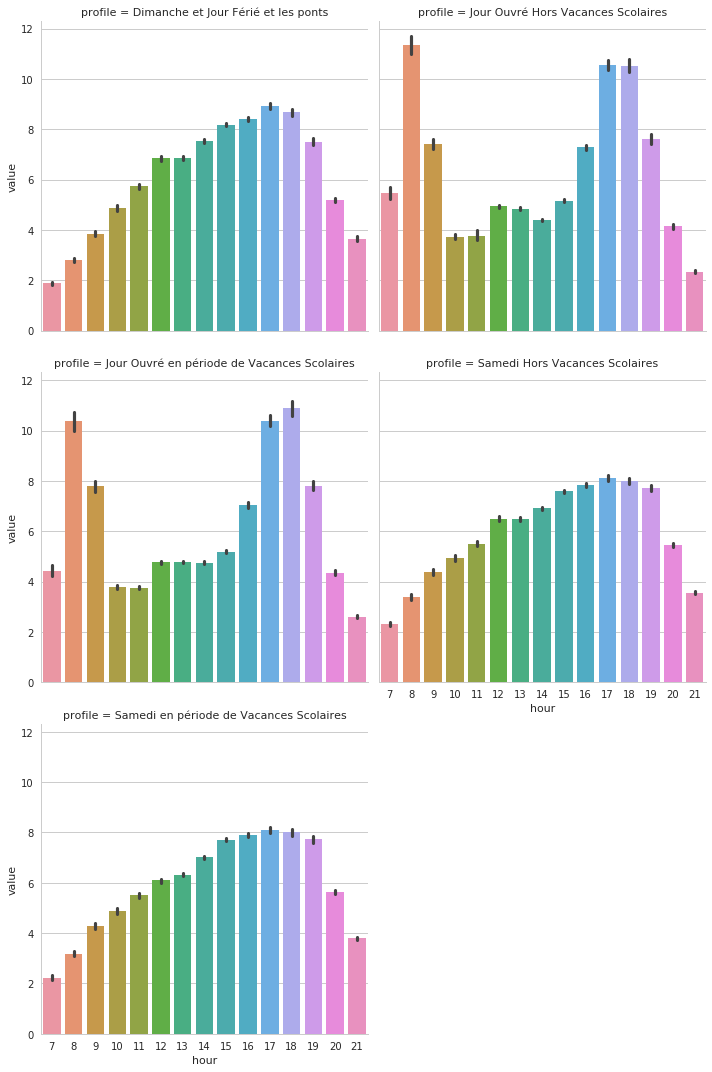

In [42]:
sns.factorplot(
    x='hour',
    y='value',
    col='profile',
    data=df_clean,
    kind='bar',
    size=5,
    col_wrap=2
)

In [ ]:
#ax=sns.boxplot(x='heure',y='value',hue='hour',data=df_ouvre.query('heure>=6'))